Hey!

TL;DR: **run the whole notebook** :)

Enter your ClientID and CLient secret when asked.

Down below, an object of a custom class `SongCollector()` will be created, which has a function `collect_songs_from_playlists(<playlist_ids>, remove_duplicates={True|False})`

An object of that collector is then created in a variable called `my_songcollector` and its function `.collect_songs_from_playlists(playlist_ids)` is executed for a list of `playlist_ids`

The process will then run through (takes maybe a minute or so), and you can easily extract the dataframe out of 
`my_songcollector` with

```python
my_songcollector.df
```

The class is pretty hardcoded, there are probably more elegant solutions ;)

In [4]:
import json
from IPython.display import Image

import pandas as pd
from tqdm.notebook import tqdm

# Importing spotify API stuff
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import getpass
import time
import random
import requests

import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns

# Machine learning
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score

# Import my custom modules in the same folder (saved as .py files)
# from scrape_billboard import scrape_billboard
# import recommender_mvp


In [6]:
client_id = getpass.getpass(prompt="Spotify client_id: 0c1986b028b5499b8e68fc9b91235e1c")
client_secret = getpass.getpass(prompt="Spotify client_secret:c1cb62d8afd4630a50c6a0d21a11467")

#Initialize a SpotiPy instance with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret)
                    )

Spotify client_id:0c1986b028b5499b8e68fc9b91235e1c········
Spotify client_secret:c1cb62d8afd4630a50c6a0d21a11467········


In [7]:
#Function to get the artists involved in a song:

def get_artists_from_track(track):
    return [artist["name"] for artist in track["artists"]]

In [8]:
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify", playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

def create_df_from_tracks(tracks):
    # making sure we only get track who really have an id
    tracks = [track for track in tracks if track_exists(track) and id_exists(track)]
    #tracks = [track for track in tracks if id_exists(track)]
    
    # getting all the ids from the tracks
    ids = [get_id(track) for track in tracks]
    
    # Getting the song features from the song ids
    # Warning: Only 100 tracks here
    
    features = sp.audio_features(ids)
    
    try:
        df = pd.DataFrame({'name': [track['track']['name'] for track in tracks],
                           # a track can have mulitple artists. if so, add them seperated by ","
                           'artists': [", ".join([artist['name'] for artist in track['track']['artists']]) for track in tracks],
                           # 'ids': ids,
                          })
        
        # Creating a dataframe from the features 
        df_features = pd.DataFrame(features)
        
        return pd.concat([df, df_features], axis=1)
    
    except AttributeError:
        return pd.DataFrame(columns=['name',
                                     'danceability',
                                        'energy',
                                        'key',
                                        'loudness',
                                        'mode',
                                        'speechiness',
                                        'acousticness',
                                        'instrumentalness',
                                        'liveness',
                                        'valence',
                                        'tempo',
                                        'type',
                                        'id',
                                        'uri',
                                        'track_href',
                                        'analysis_url',
                                        'duration_ms',
                                        'time_signature'],
                           )

def get_id(track):
        return track['track']['id']
    
def id_exists(track):
    return bool(get_id(track))

def track_exists(track):
    return track['track']

In [9]:
import pandas as pd

# The Class - which is the blueprint of the robot. You can build multiple robots with different 
# attributes from it
class SongCollector:
    
    # the "constructor" method. These things should happen, when our robot is created
    def __init__(self, dataframe=pd.DataFrame()):
        # "self", the "identity" or consciousness of your individual robot.
        # in this case we say that when the user wants to create the robot with a song dataframe already 
        # in its pocket, the user can initialize it with that and it gets added to the robots "identity"
        self.df = dataframe
        
    # one "ability" of the robot
    def collect_songs_from_playlists(self,
                                     playlist_ids,
                                     remove_duplicates=False):
        """
        Takes the dataframe stored in self.df and expands it by the songs 
        provided by the user in the list <playlists>
        
        playlists: A list of spotify playlist URIs as strings
        """
        for playlist_id in tqdm(playlist_ids):
            tracks = get_playlist_tracks(playlist_id)
            try:
                playlist_df = create_df_from_tracks(tracks)
                self.df = pd.concat([self.df, playlist_df], axis=0)
            except (requests.HTTPError, spotipy.client.SpotifyException) as exception:
                # print(exception)
                continue
            
        # the robot should return the resulting dataframe
        return self.df

In [10]:
# check the 'country' or the 'locale' keyword in categories() to customize your playlist selection 
categories = sp.categories()

In [11]:
categories_dct = {cat['name']: cat['id'] for cat in categories['categories']['items']}
categories_dct

{'Top Lists': 'toplists',
 'Pop': 'pop',
 'Workout': 'workout',
 'Hip Hop': 'hiphop',
 'Wellness': 'wellness',
 'Mood': 'mood',
 'Party': 'party',
 'Alternative': 'alternative',
 'At Home': 'at_home',
 'Dance/Electronic': 'edm_dance',
 'Rock': 'rock',
 'Black History Is Now': 'blackhistorymonth',
 'R&B': 'rnb',
 'In the car': 'in_the_car',
 'Indie': 'indie_alt',
 'Chill': 'chill',
 'Throwback': 'throwback',
 'Caribbean': 'caribbean',
 'Gaming': 'gaming',
 'Sleep': 'sleep'}

In [18]:
# and for all
playlist_ids = []

for cat_id in categories_dct.values():
    pl_per_categeroy_json = sp.category_playlists(cat_id)['playlists']['items']
    
    print(pl_per_categeroy_json)
    for pl in pl_per_categeroy_json:
        try:
            id_ = pl['id']
        except TypeError:
            continue
        playlist_ids.append(f"spotify:playlist:{id_}")


my_songcollector = SongCollector()

my_songcollector.collect_songs_from_playlists(playlist_ids)

[{'collaborative': False, 'description': 'Lil Tjay & 6LACK are on top of the Hottest 50!', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M', 'id': '37i9dQZF1DXcBWIGoYBM5M', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67706f00000003d4c4153e581b2a64d32daece', 'width': None}], 'name': "Today's Top Hits", 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTYxNDMxNTY5MCwwMDAwMDQ4MjAwMDAwMTc3ZGNiNjliMGEwMDAwMDE3N2RjMzUwMDYy', 'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M/tracks', 'total': 50}, 'type': 'playlist', 'uri': 'spotify:playlist:37i9dQZF1DXcBWIGoYBM5M'}, {'collaborative': False, 'description': 'Ne

[{'collaborative': False, 'description': 'New music from Pop Smoke and Drakeo The Ruler featuring Drake.', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX0XUsuxWHRQd'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0XUsuxWHRQd', 'id': '37i9dQZF1DX0XUsuxWHRQd', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67706f000000036bf0bdfbce2e64e1b4f45500', 'width': None}], 'name': 'RapCaviar', 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTYxNDQ0NTAyNSwwMDAwMDU1MjAwMDAwMTc3ZTQ2YzE5YTcwMDAwMDE3N2RhMzUzM2Fh', 'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0XUsuxWHRQd/tracks', 'total': 50}, 'type': 'playlist', 'uri': 'spotify:playlist:37i9dQZF1DX0XUsuxWHRQd'}, {'collaborative': False, 'descript

HTTP Error for GET to https://api.spotify.com/v1/browse/categories/alternative/playlists returned 404 due to Specified id doesn't exist


[{'collaborative': False, 'description': "Get happy with today's dose of feel-good songs!", 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX3rxVfibe1L0'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX3rxVfibe1L0', 'id': '37i9dQZF1DX3rxVfibe1L0', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67706f00000003aa93fe4e8c2d24fc62556cba', 'width': None}], 'name': 'Mood Booster', 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTYxNDUyMjM1NywwMDAwMDAwMGQ0MWQ4Y2Q5OGYwMGIyMDRlOTgwMDk5OGVjZjg0Mjdl', 'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX3rxVfibe1L0/tracks', 'total': 76}, 'type': 'playlist', 'uri': 'spotify:playlist:37i9dQZF1DX3rxVfibe1L0'}, {'collaborative': False, 'description': 'Feel 

SpotifyException: http status: 404, code:-1 - https://api.spotify.com/v1/browse/categories/alternative/playlists?limit=20&offset=0:
 Specified id doesn't exist, reason: None

In [19]:
# run this to get returned the dataframe of songs with their audiofeatures that were collected
my_songcollector.df

NameError: name 'my_songcollector' is not defined

In [20]:
#dir(my_songcollector.df)

In [17]:
my_df = my_songcollector.df

NameError: name 'my_songcollector' is not defined

In [63]:
my_df =my_df.drop_duplicates(subset=['id'])

In [64]:
my_df.head()

,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,0
0,Save Your Tears,The Weeknd,0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,...,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4,NaN
1,Goosebumps - Remix,"Travis Scott, HVME",0.841,0.593,1,-7.846,1,0.0379,0.4180,0.000000,...,0.808,124.917,audio_features,5uEYRdEIh9Bo4fpjDd4Na9,spotify:track:5uEYRdEIh9Bo4fpjDd4Na9,https://api.spotify.com/v1/tracks/5uEYRdEIh9Bo...,https://api.spotify.com/v1/audio-analysis/5uEY...,162803,4,NaN
2,test drive,Ariana Grande,0.698,0.708,9,-4.943,0,0.0454,0.0251,0.000000,...,0.322,115.036,audio_features,3eZYOQO4UzKrUDYDghtnFw,spotify:track:3eZYOQO4UzKrUDYDghtnFw,https://api.spotify.com/v1/tracks/3eZYOQO4UzKr...,https://api.spotify.com/v1/audio-analysis/3eZY...,122174,4,NaN
3,We're Good,Dua Lipa,0.722,0.588,6,-5.932,1,0.0544,0.0319,0.000000,...,0.590,134.010,audio_features,1diS6nkxMQc3wwC4G1j0bh,spotify:track:1diS6nkxMQc3wwC4G1j0bh,https://api.spotify.com/v1/tracks/1diS6nkxMQc3...,https://api.spotify.com/v1/audio-analysis/1diS...,165507,4,NaN
4,drivers license,Olivia Rodrigo,0.585,0.436,10,-8.761,1,0.0601,0.7210,0.000013,...,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4,NaN


In [66]:
my_df.shape

(8127, 21)

## Clustering
Everything from now on is the work we did together today (25.02.2021)

In [67]:
#dropping the non-numerical columns and storing everything in df2
df2 = my_df.drop(columns=['name', 'artists', 'type', 'id', 'uri', 'track_href', 'analysis_url',0],axis=1)

In [68]:
df2.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.543,0.644,118.051,215627,4
1,0.841,0.593,1,-7.846,1,0.0379,0.4180,0.000000,0.124,0.808,124.917,162803,4
2,0.698,0.708,9,-4.943,0,0.0454,0.0251,0.000000,0.124,0.322,115.036,122174,4
3,0.722,0.588,6,-5.932,1,0.0544,0.0319,0.000000,0.183,0.590,134.010,165507,4
4,0.585,0.436,10,-8.761,1,0.0601,0.7210,0.000013,0.105,0.132,143.874,242014,4


In [70]:
from sklearn.preprocessing import StandardScaler
df2 = StandardScaler().fit_transform(df2)

In [71]:
#df2 is now standard scaled and shows up as an array (no longer a data frame)
df2

array([[ 0.6273059 ,  0.81909974, -1.4609046 , ..., -0.08725665,
        -0.21280089,  0.21638609],
       [ 1.4937686 , -0.04252515, -1.17990688, ...,  0.14656502,
        -0.86148399,  0.21638609],
       [ 0.72417751,  0.38274035,  1.0680749 , ..., -0.18993249,
        -1.36041149,  0.21638609],
       ...,
       [-0.05617709, -0.92633781, -1.4609046 , ..., -1.40644542,
         2.44166186, -2.3808862 ],
       [-0.61587971, -0.90415004,  0.50607946, ..., -1.41999932,
        -0.31333793, -2.3808862 ],
       [ 0.45508971, -2.09785182,  0.22508174, ..., -1.76150292,
        -1.11826053,  0.21638609]])

In [72]:
# converting the df2 array into the df3 data frame
df3 = pd.DataFrame(df2)

In [73]:
#checking for nulls
print(df3.isnull().sum())#.sum())

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
dtype: int64


In [74]:
#dropping the nulls and storing this inside the new data frame df4 (saving df3 though, just be sure;))
df4=df3.dropna()

In [75]:
#defining the kmeans with randomly chosen 8 clusters 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(df4)

# print the cluster centers
clusters = kmeans.cluster_centers_

print(clusters)
#clusters occure as array

[[ 0.20722871  0.54725188 -0.1193218   0.46270576  0.74692622 -0.22597832
  -0.54447612 -0.3679356  -0.24086161  0.4702005   0.17622387 -0.20650573
   0.15583353]
 [-1.26073365 -1.53609321  0.01238207 -1.68779072  0.0323649  -0.3994539
   1.38289647  1.2168305  -0.36990576 -1.127192   -0.38949365  0.00771924
  -3.0722897 ]
 [ 0.3913986   0.50602858  0.23477762  0.46241773 -1.33882032 -0.07797683
  -0.5105107  -0.38003011 -0.18284928  0.3505615   0.05781839 -0.21861421
   0.16903998]
 [-0.07767536 -0.89479581 -0.05791775 -0.24602493  0.3160329  -0.456944
   1.06405028 -0.4126469  -0.29921407 -0.40471565 -0.28513261 -0.07993801
   0.12618696]
 [ 0.84471872  0.20720371 -0.02993031  0.33658768 -0.14229488  2.81558957
  -0.37969206 -0.53831225  0.04803015  0.37240275  0.17252038 -0.35343609
   0.21231513]
 [-1.22258943 -1.70685746 -0.03791457 -1.99191654  0.00387901 -0.42040683
   1.57916085  1.76514316 -0.34681194 -1.17074201 -0.66637943  0.08633679
   0.41523975]
 [ 0.0752501  -0.06495447

In [21]:
#clusters = kmeans.predict(df4)

In [78]:
# printing the cluster we have
print(clusters)

[7 0 2 ... 6 1 5]


In [79]:
#putting the clusters into a series and checking for the value counts
pd.Series(clusters).value_counts().sort_index()

0    2403
1     433
2    1536
3    1121
4     638
5     640
6     594
7     761
dtype: int64

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

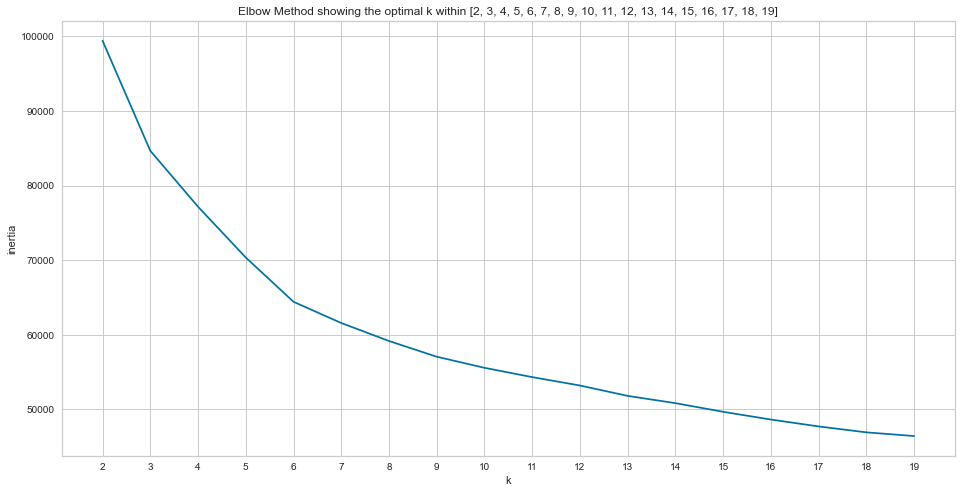

In [183]:
#showing the optimal k and storing the inertias inside a list
import numpy as np
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(df4)
    inertias.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

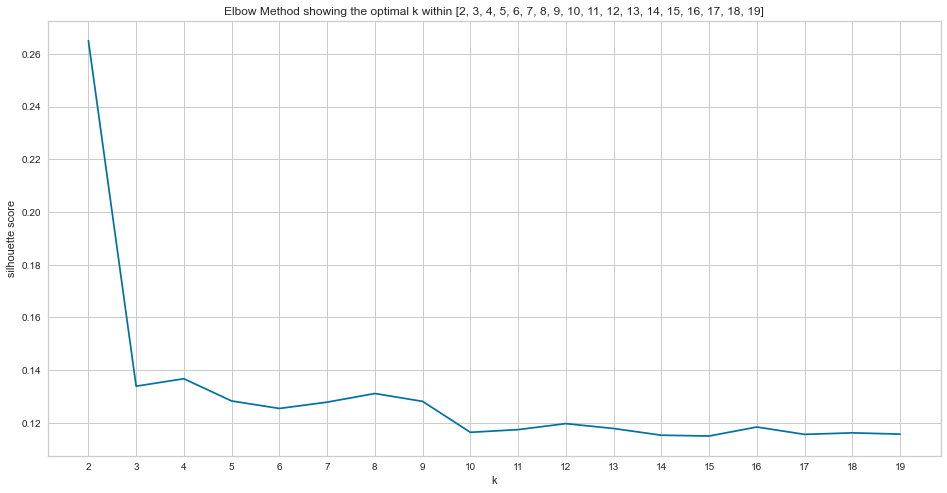

In [80]:
# Silhouette Score
from sklearn.metrics import silhouette_score

import numpy as np
K = range(2,20)
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(df4)
    silhouettes.append(silhouette_score(df4,
                                     kmeans.predict(df4)
                                    )
                   )
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

IndexError: index 2 is out of bounds for axis 0 with size 2

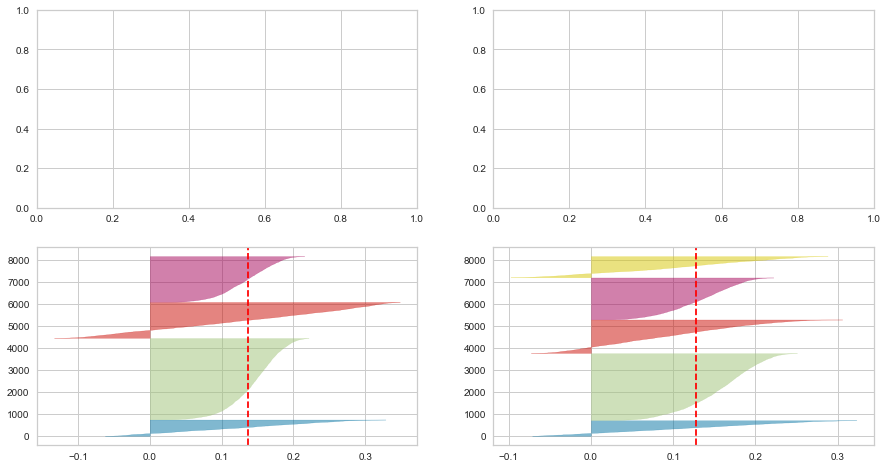

In [83]:
# was not working well
'''
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for k in [4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k,
                random_state=1234)
    q, mod = divmod(k, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df4)
'''

### From here it gets a bit messy not sure about how comment

In [ ]:
# we decided we go on with 6 clusters

In [84]:
kmeans = KMeans(n_clusters=6,
               random_state=1234)
kmeans.fit(df4)

clusters = kmeans.predict(df4)

In [85]:
clusters.shape

(8126,)

In [51]:
df4_clustered = pd.DataFrame(df4, columns=['danceability',
                                           'energy',
                                           'key',
                                           'loudness',
                                           'mode',
                                           'speechiness',
                                           'acousticness',
                                           'instrumentalness',
                                           'liveness',
                                           'valence',
                                           'tempo',
                                           'duration_ms',
                                           'time_signature'])

In [86]:
df4.columns=(['danceability',
                                           'energy',
                                           'key',
                                           'loudness',
                                           'mode',
                                           'speechiness',
                                           'acousticness',
                                           'instrumentalness',
                                           'liveness',
                                           'valence',
                                           'tempo',
                                           'duration_ms',
                                           'time_signature'])

In [87]:
df4

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.627306,0.819100,-1.460905,0.603404,0.746926,-0.601004,-0.818580,-0.587252,2.692803,0.724550,-0.087257,-0.212801,0.216386
1,1.493769,-0.042525,-1.179907,0.239063,0.746926,-0.515079,0.329933,-0.587288,-0.342688,1.363582,0.146565,-0.861484,0.216386
2,0.724178,0.382740,1.068075,0.687423,-1.338820,-0.423015,-0.807292,-0.587288,-0.342688,-0.530134,-0.189932,-1.360411,0.216386
3,0.853340,-0.061015,0.225082,0.534675,0.746926,-0.312539,-0.787610,-0.587288,0.084744,0.514137,0.456227,-0.828279,0.216386
4,0.116039,-0.623105,1.349073,0.097744,0.746926,-0.242571,1.206948,-0.587249,-0.480336,-1.270476,0.792146,0.111234,0.216386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8122,-0.422136,-1.736191,0.225082,-1.477154,-1.338820,-0.542084,1.988446,2.066569,0.005053,-0.966546,-0.120358,-1.427105,-2.380886
8123,-0.083086,-1.882261,-1.179907,-2.028994,0.746926,-0.528581,1.264837,2.133866,-0.429623,-1.553365,0.296918,0.983279,0.216386
8124,-0.056177,-0.926338,-1.460905,-0.898750,0.746926,-0.448793,1.311148,1.990493,-0.429623,0.872618,-1.406445,2.441662,-2.380886
8125,-0.615880,-0.904150,0.506079,-1.310969,0.746926,1.597468,1.991341,2.010975,-0.103616,-1.032788,-1.419999,-0.313338,-2.380886


In [88]:
df4['cluster_id'] = clusters

<ipython-input-88-f5fd5b7b62d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['cluster_id'] = clusters


In [89]:
df4

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster_id
0,0.627306,0.819100,-1.460905,0.603404,0.746926,-0.601004,-0.818580,-0.587252,2.692803,0.724550,-0.087257,-0.212801,0.216386,5
1,1.493769,-0.042525,-1.179907,0.239063,0.746926,-0.515079,0.329933,-0.587288,-0.342688,1.363582,0.146565,-0.861484,0.216386,1
2,0.724178,0.382740,1.068075,0.687423,-1.338820,-0.423015,-0.807292,-0.587288,-0.342688,-0.530134,-0.189932,-1.360411,0.216386,3
3,0.853340,-0.061015,0.225082,0.534675,0.746926,-0.312539,-0.787610,-0.587288,0.084744,0.514137,0.456227,-0.828279,0.216386,1
4,0.116039,-0.623105,1.349073,0.097744,0.746926,-0.242571,1.206948,-0.587249,-0.480336,-1.270476,0.792146,0.111234,0.216386,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8122,-0.422136,-1.736191,0.225082,-1.477154,-1.338820,-0.542084,1.988446,2.066569,0.005053,-0.966546,-0.120358,-1.427105,-2.380886,4
8123,-0.083086,-1.882261,-1.179907,-2.028994,0.746926,-0.528581,1.264837,2.133866,-0.429623,-1.553365,0.296918,0.983279,0.216386,4
8124,-0.056177,-0.926338,-1.460905,-0.898750,0.746926,-0.448793,1.311148,1.990493,-0.429623,0.872618,-1.406445,2.441662,-2.380886,4
8125,-0.615880,-0.904150,0.506079,-1.310969,0.746926,1.597468,1.991341,2.010975,-0.103616,-1.032788,-1.419999,-0.313338,-2.380886,4


In [98]:
kmeans.cluster_centers_

array([[ 0.84676738,  0.20477934, -0.01759812,  0.32944689, -0.16953817,
         2.77552487, -0.38025183, -0.52806072,  0.03101728,  0.37069323,
         0.16494735, -0.34721304,  0.184904  ],
       [ 0.20946943,  0.52694948, -0.10948556,  0.4316491 ,  0.74692622,
        -0.23313907, -0.54079112, -0.24937599, -0.25395158,  0.41064006,
         0.17469535, -0.10233566,  0.13568833],
       [-0.15175156, -0.90329829, -0.05241638, -0.32165726,  0.26712811,
        -0.45507626,  1.06010983, -0.15225643, -0.30066254, -0.46236188,
        -0.24444201,  0.166071  , -0.05190358],
       [ 0.38710948,  0.47378088,  0.23569466,  0.4000127 , -1.33882032,
        -0.12423156, -0.50133648, -0.15879411, -0.2178136 ,  0.27303482,
         0.0549177 , -0.00632102,  0.16658365],
       [-1.32629507, -1.70227921, -0.0123771 , -2.02662306, -0.02698993,
        -0.41551008,  1.52792684,  1.73838762, -0.36578378, -1.21044182,
        -0.59694876,  0.26933713, -0.79234046],
       [-0.33198529,  0.730618

In [153]:
df4.shape

(8126, 14)

In [154]:
kmeans_cluster_center_ = pd.DataFrame(kmeans.cluster_centers_)

In [155]:
kmeans_cluster_center_.shape

(6, 13)

In [156]:
columns_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                                           'instrumentalness',
                                           'liveness',
                                           'valence',
                                           'tempo',
                                           'duration_ms',
                                           'time_signature']

In [157]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=columns_names)

In [158]:
cluster_centers_df['cluster_id'] = range(0,6)

In [159]:
cluster_centers_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster_id
0,0.846767,0.204779,-0.017598,0.329447,-0.169538,2.775525,-0.380252,-0.528061,0.031017,0.370693,0.164947,-0.347213,0.184904,0
1,0.209469,0.526949,-0.109486,0.431649,0.746926,-0.233139,-0.540791,-0.249376,-0.253952,0.410640,0.174695,-0.102336,0.135688,1
2,-0.151752,-0.903298,-0.052416,-0.321657,0.267128,-0.455076,1.060110,-0.152256,-0.300663,-0.462362,-0.244442,0.166071,-0.051904,2
3,0.387109,0.473781,0.235695,0.400013,-1.338820,-0.124232,-0.501336,-0.158794,-0.217814,0.273035,0.054918,-0.006321,0.166584,3
4,-1.326295,-1.702279,-0.012377,-2.026623,-0.026990,-0.415510,1.527927,1.738388,-0.365784,-1.210442,-0.596949,0.269337,-0.792340,4
5,-0.331985,0.730618,-0.031435,0.500017,0.164919,0.023414,-0.533254,-0.284849,2.254641,0.042271,0.328865,0.020103,0.108166,5


In [ ]:
get.unique('duration_ms')

In [147]:
cluster_centers_df = cluster_centers_df[['danceability', 'tempo', 'cluster_id']]

df4_clusters = df4[['danceability', 'tempo', 'cluster_id']]

<AxesSubplot:xlabel='danceability', ylabel='tempo'>

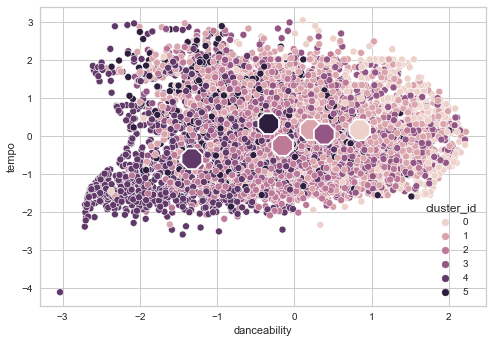

In [148]:
import seaborn as sns

#plot datapoints
sns.scatterplot(data=df4_clusters,
               x="danceability",
               y="tempo",
               hue='cluster_id',
                legend=False)

#plot centroids
sns.scatterplot(data=cluster_centers_df,
               x="danceability",
               y="tempo",
               hue='cluster_id',
                legend=True,
                marker=u'8',
                s=500)


In [151]:
cluster_centers_df = cluster_centers_df[['instrumentalness', 'loudness', 'cluster_id']]

df4_clusters = df4[['instrumentalness', 'loudness', 'cluster_id']]

KeyError: "['instrumentalness', 'loudness'] not in index"

In [ ]:
#plot datapoints
sns.scatterplot(data=df4_clusters,
               x="instrumentalness",
               y="loudness",
               hue='cluster_id',
                legend=False)

#plot centroids
sns.scatterplot(data=cluster_centers_df,
               x="instrumentalness",
               y="loudness",
               hue='cluster_id',
                legend=True,
                marker=u'8',
                s=500)


In [ ]:
import seaborn as sns
sns.scatterplot(data=wines_sub_df,
               x='alcohol',
               y='color_intensity',
               hue='cluster_id')

In [ ]:
len(clusters)

In [ ]:
len(df4)